The FAA comes to us with data, and asks, "Why are delays not improving?"

Monday, come in, and say: "Here's what's going on ... "
* What operational factors are correlated to delays? (Are there any relationships?)
* Present a (cleaned) notebook, a slide deck, or the blog post. But _in any case_ deliver a clear story with good visualizations.
* Begin presentation with Problem Statement -- Solution before going into analysis. (I.e., the abstract)
* Use Problem statement --- Code --- Report layout for notebook.

PCA analysis is key. Use these to find the principle components behind delays.

Do PCA. Look at eigenvectors with the highest eigenvalue. The eigenvector corresponds to feature weights. Can you combine different eigenpairs to find the most significant features?

### Project pseudocode
* Import data to database for fast querying
* Create relevant dataframes. Do initial analysis for the aggregate over all airports, then look at individual airports (the outliers)
* Clean data
* Exploratory data analysis
* Engineer features, if necessary
* Perform PCA
* Analysis
* Synthesize analysis into presentation

# Code

### Initialize libraries and settings

In [1]:
# Databases (practice)
import sqlalchemy

# Data analysis
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Import data

In [2]:
cancellations_raw_data = pd.read_csv("~/DSI-course-materials/curriculum/03-projects/01-projects-weekly/project-07/assets/airport_cancellations.csv")
operations_raw_data = pd.read_csv("~/DSI-course-materials/curriculum/03-projects/01-projects-weekly/project-07/assets/airport_operations.csv")
airports_raw_data = pd.read_csv("~/DSI-course-materials/curriculum/03-projects/01-projects-weekly/project-07/assets/airports.csv")

_Loading the csv files to a database is for practice; it's not necessary for analysis._

In [3]:
# engine = sqlalchemy.create_engine("postgres://Nathan:@localhost/DSI-coursework")

# connection = engine.connect()

# try:
#     cancellations_raw_data.to_sql(name = "cancellations_data", con = connection)
# except:
#     pass

# try:
#     operations_raw_data.to_sql(name = "operations_data", con = connection)
# except:
#     pass

# try:
#     airports_raw_data.to_sql(name = "airports_data", con = connection)
# except:
#     pass

# connection.close()

In [4]:
# cancellations_raw_data = pd.read_sql_query("select * from cancellations_data", engine)
# operations_raw_data = pd.read_sql_query("select * from operations_data", engine)
# airports_raw_data = pd.read_sql_query("select * from airports_data", engine)

# print(cancellations_raw_data.head(2))
# print(operations_raw_data.head(2))
# print(airports_raw_data.head(2))

In [5]:
# raw_master_dataframe = pd.read_sql_query("""
# SELECT * 
# FROM cancellations_data 
# JOIN operations_data 
#     ON operations_data.airport = cancellations_data.Airport 
# JOIN airports_data 
#     ON cancellations_data.Airport = airports_data.LocID
#     """, engine)

In [6]:
operations_data = operations_raw_data.copy()
cancellations_data = cancellations_raw_data.copy()
airports_data = airports_raw_data.copy()

In [7]:
# Rename columns in "operations_data" to match case
for column_name in operations_data.columns:
    operations_data.rename(columns = {column_name: column_name.title()}, inplace = True)

In [8]:
master_dataframe = cancellations_data.merge(operations_data, on = ["Airport", "Year"]).merge(airports_data.rename(columns = {"LocID": "Airport"}), on = ["Airport"])

In [9]:
data_dataframe = master_dataframe.copy()

In [99]:
data_dataframe.drop(labels = ["Key", "Facility Type", "COUNTY", "Boundary Data Available"], axis = 1, inplace = True)
data_dataframe["Year"] = data_dataframe["Year"].astype(int)

ValueError: labels ['Key' 'Facility Type'] not contained in axis

### Data exploration

In [11]:
print(data_dataframe.columns)
data_dataframe.info()

Index(['Airport', 'Year', 'Departure Cancellations', 'Arrival Cancellations',
       'Departure Diversions', 'Arrival Diversions',
       'Departures For Metric Computation', 'Arrivals For Metric Computation',
       'Percent On-Time Gate Departures', 'Percent On-Time Airport Departures',
       'Percent On-Time Gate Arrivals', 'Average_Gate_Departure_Delay',
       'Average_Taxi_Out_Time', 'Average Taxi Out Delay',
       'Average Airport Departure Delay', 'Average Airborne Delay',
       'Average Taxi In Delay', 'Average Block Delay',
       'Average Gate Arrival Delay', 'AP_NAME', 'ALIAS', 'FAA REGION',
       'COUNTY', 'CITY', 'STATE', 'AP Type', 'Latitude', 'Longitude',
       'Boundary Data Available'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 29 columns):
Airport                               799 non-null object
Year                                  799 non-null int64
Departure Cancellations               7

In [12]:
data_dataframe["AP Type"].value_counts()
international_mask = (data_dataframe["AP_NAME"].str.contains("INTL") | data_dataframe["ALIAS"].str.contains("Inter"))
# data_dataframe["International"] = 
data_dataframe["International"] = (~ international_mask).map({True: 1, False: 0})

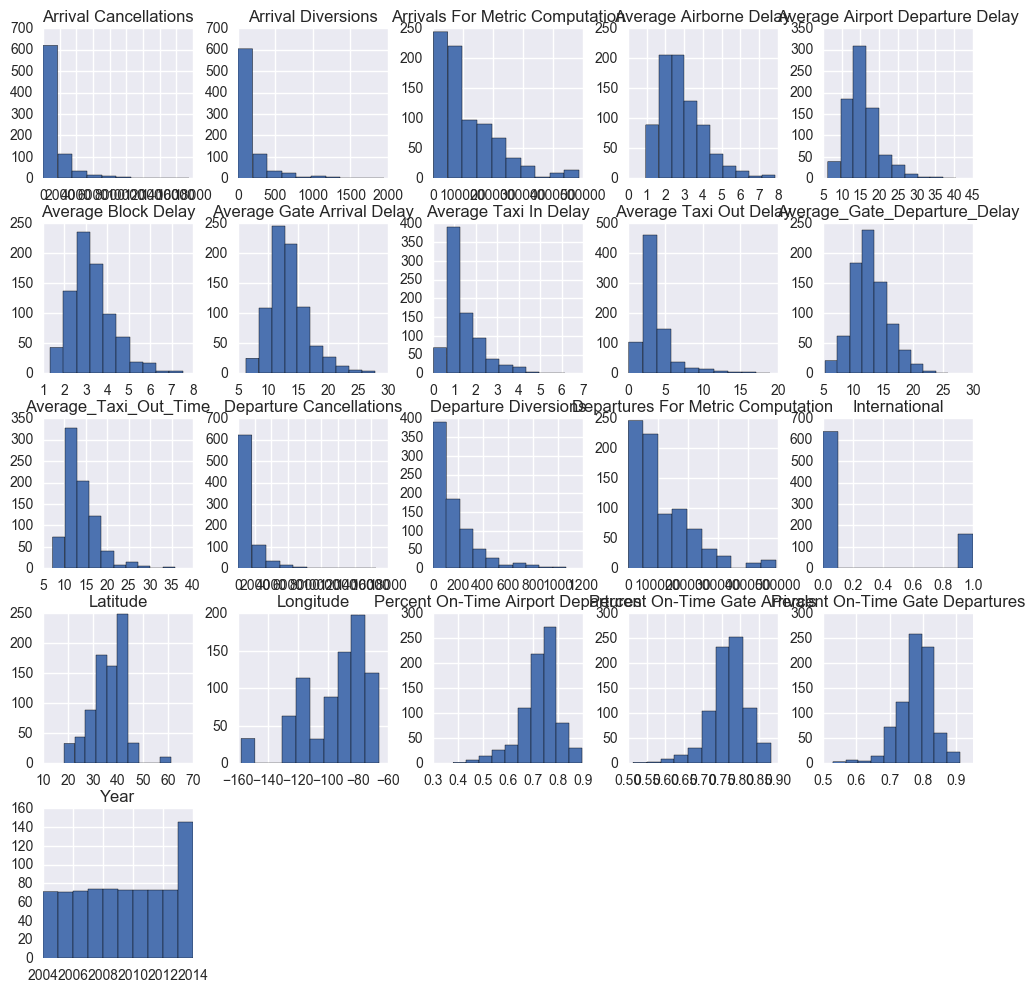

In [13]:
data_dataframe.hist(figsize=(12, 12))
plt.show()

In [14]:
# Checking to see why there's a jump in 2013-2014. It's an artifact.
data_dataframe[data_dataframe["Year"] == 2014]['Airport'].count() - data_dataframe[data_dataframe["Year"] == 2013]['Airport'].count()

-1

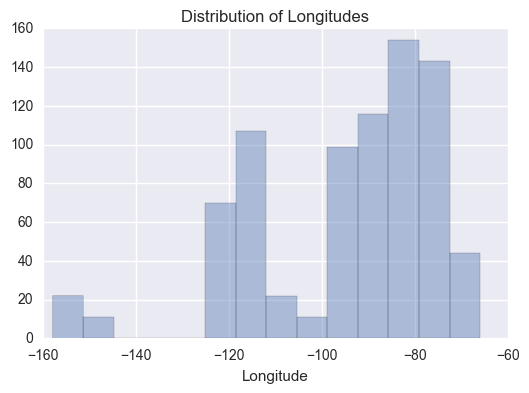

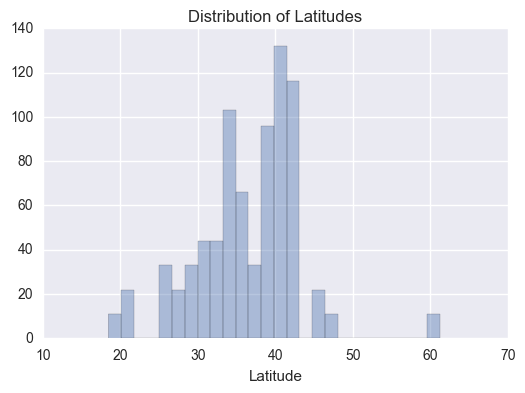

In [15]:
sns.distplot(data_dataframe["Longitude"], kde = False, label = "Longitude")
plt.title("Distribution of Longitudes")
plt.show()

sns.distplot(data_dataframe["Latitude"], kde = False, label = "Latitude")
plt.title("Distribution of Latitudes")
plt.show()

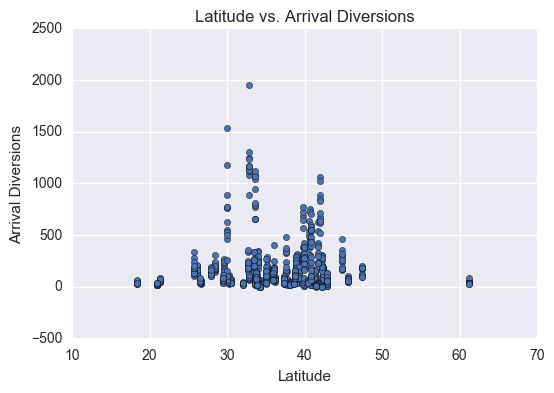

In [16]:
data_dataframe.plot.scatter(x = "Latitude", y = 'Arrival Diversions')
plt.title("Latitude vs. Arrival Diversions")
plt.show()

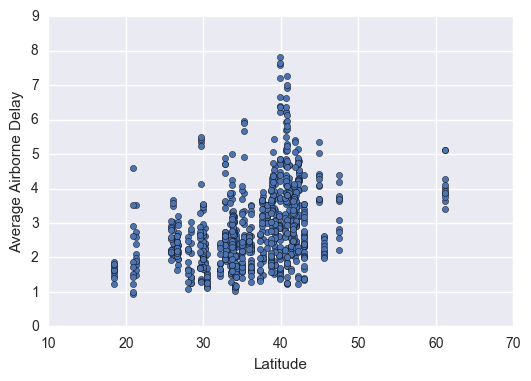

In [83]:
data_dataframe.plot.scatter(x = "Latitude", y = 'Average Airborne Delay')
plt.show()

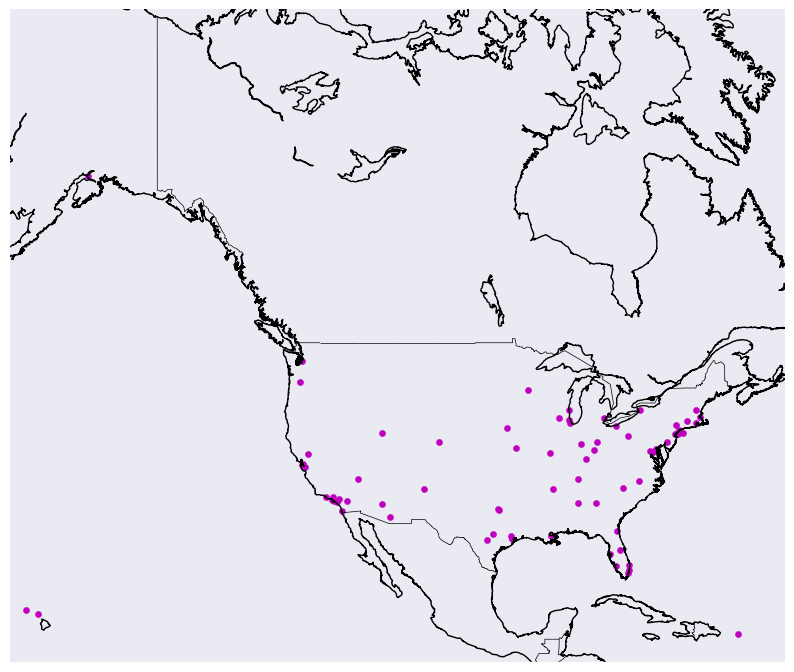

In [80]:
from mpl_toolkits.basemap import Basemap

map_fig = plt.figure(figsize=(10, 10))

map = Basemap(llcrnrlon=-160.,llcrnrlat=15.,urcrnrlon=-60.,urcrnrlat=70.,
             resolution='i', area_thresh = 10000, projection='merc')

map.drawcoastlines()
map.drawcountries()

latitudes = data_dataframe.groupby(by = "Airport").mean()["Latitude"].tolist()
longitudes = data_dataframe.groupby(by = "Airport").mean()["Longitude"].tolist()

x, y = map(longitudes, latitudes)
map.scatter(x, y, color='m')


plt.show()

### PCA

In [19]:
numerical_mask = (data_dataframe.dtypes == int) | (data_dataframe.dtypes == float)
data_grouped_by_airport = data_dataframe.groupby(by = "Airport").mean()

X = data_grouped_by_airport.ix[:, numerical_mask].drop(labels = ["Year", "International"], axis = 1)
y = data_grouped_by_airport["International"]

scaled_X = StandardScaler().fit_transform(X)

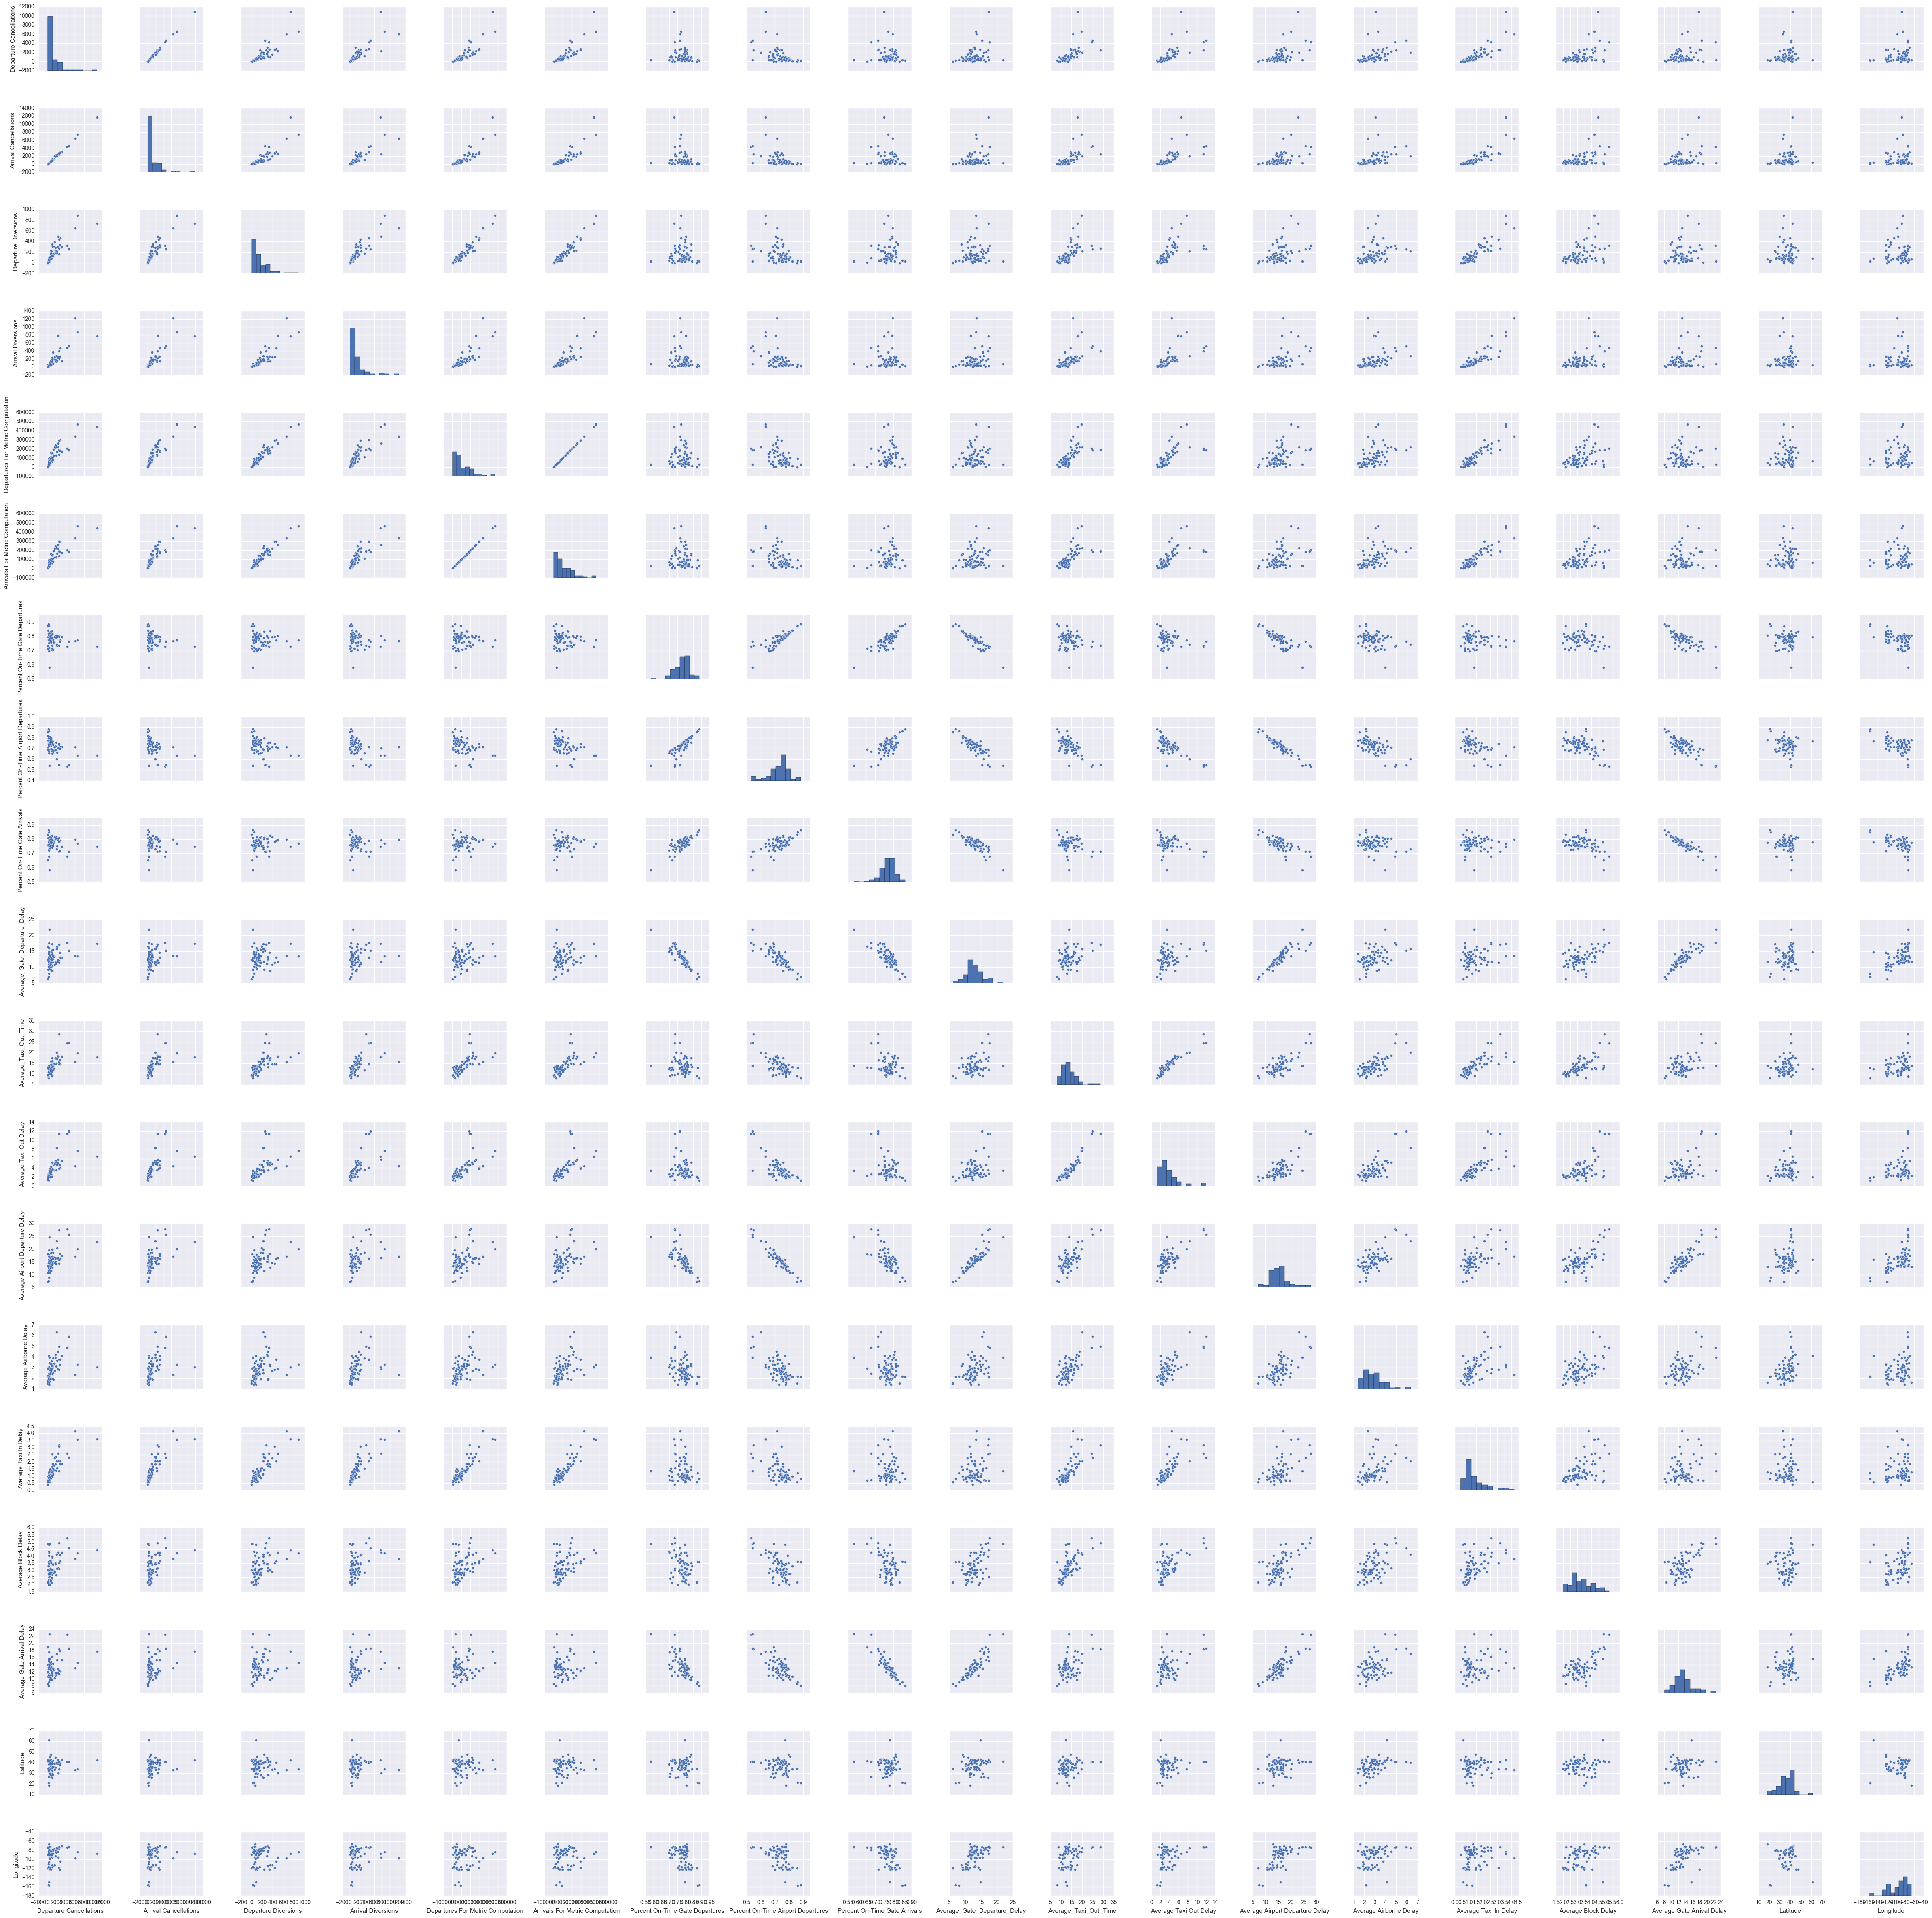

In [22]:
sns.pairplot(X)
plt.show()

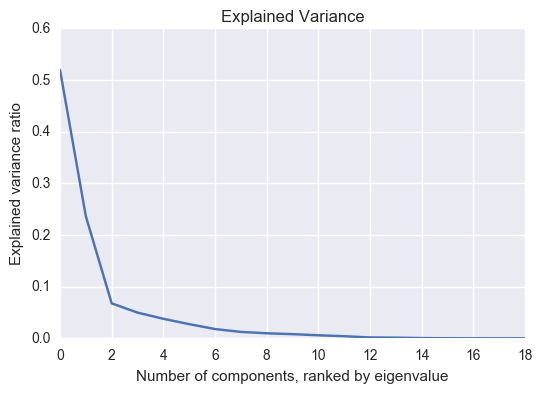

In [23]:
pca = PCA()
PCA_explained_variance = pca.fit(scaled_X).explained_variance_ratio_

sns.plt.plot(PCA_explained_variance)

plt.title("Explained Variance")
plt.xlabel("Number of components, ranked by eigenvalue")
plt.ylabel("Explained variance ratio")

sns.plt.show()

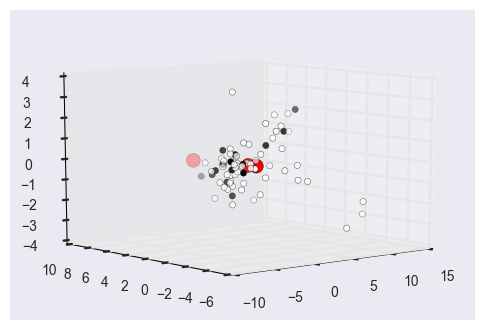

In [59]:
# Correlations with longitude?
# Arrival diversions, departure diversions?
#plt.scatter(reduced_X.T[0], reduced_X.T[1])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_X.T[0], reduced_X.T[1], reduced_X.T[2], c = y)
ax.scatter(centroids[0], centroids[1], c = 'r', s = 100)

ax.view_init(10, 230)


In [25]:
average_percent_change_dataframe = pd.DataFrame()

for airport in data_dataframe["Airport"].unique():
    average_change_by_airport = data_dataframe[data_dataframe["Airport"] == airport].ix[:, data_dataframe.dtypes == float].pct_change(periods = 1).mean()
    average_percent_change_dataframe = pd.concat(
        objs = [average_percent_change_dataframe, 
                pd.DataFrame(data = average_change_by_airport.reshape(1,-1), columns = data_dataframe.loc[:, data_dataframe.dtypes == float].columns)
               ])
    
average_percent_change_dataframe.drop(labels = ["Latitude", "Longitude"], axis = 1, inplace = 1)
average_percent_change_dataframe.replace(np.inf, value = 0, inplace = True)
average_percent_change_dataframe.reset_index(drop = True, inplace = True)
average_percent_change_dataframe["Airport"] = data_dataframe["Airport"].unique()
average_percent_change_dataframe["Airport"] = average_percent_change_dataframe["Airport"].astype('category')


In [26]:
sorted_average_percent_change_dataframe = average_percent_change_dataframe.mean().sort_values(ascending = False).to_frame(name = "Average percent change").T

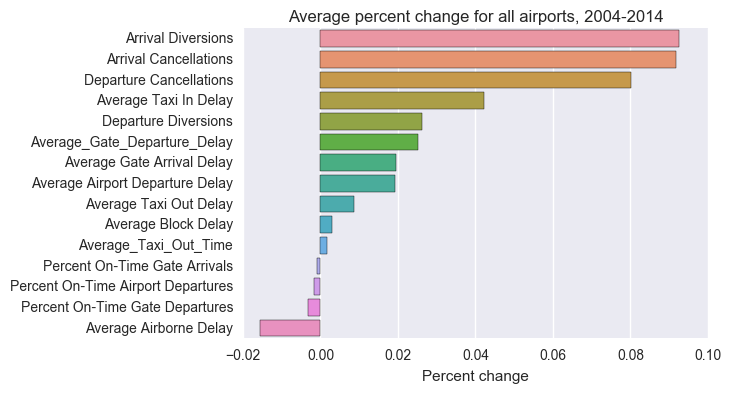

In [81]:
sns.barplot(data = sorted_average_percent_change_dataframe, orient = 'h')
plt.title("Average percent change for all airports, 2004-2014")
plt.xlabel("Percent change")
plt.show()

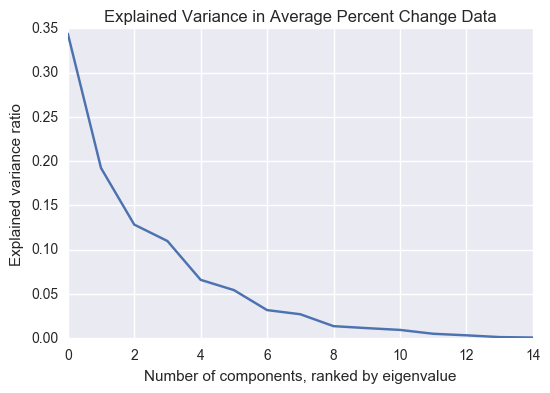

In [63]:
pct_chg_X = average_percent_change_dataframe.drop("Airport", axis = 1)
pct_chg_y = average_percent_change_dataframe["Airport"]

scaled_pct_chg_X = StandardScaler().fit_transform(pct_chg_X)
reduced_scaled_pct_chg_X = PCA().fit_transform(scaled_pct_chg_X)

pct_chg_PCA_explained_variance = PCA().fit(scaled_pct_chg_X).explained_variance_ratio_

sns.plt.plot(pct_chg_PCA_explained_variance)

plt.title("Explained Variance in Average Percent Change Data")
plt.xlabel("Number of components, ranked by eigenvalue")
plt.ylabel("Explained variance ratio")

sns.plt.show()

In [62]:
reduced_scaled_pct_chg_X

array([[-1.81673979,  0.24310996,  0.4978479 , ..., -0.1147968 ,
         0.0117468 , -0.06498517],
       [ 7.7230707 , -0.06913437, -3.80941992, ..., -0.6251731 ,
         0.28436724,  0.06412028],
       [ 4.22853087,  0.0552175 , -1.28773678, ...,  0.02176219,
        -0.29970454, -0.19498478],
       ..., 
       [ 1.33610702, -6.25012069, -1.80010658, ...,  0.07880532,
         0.03590939,  0.12441933],
       [-1.73755054, -0.37643046,  0.05721946, ...,  0.16202381,
         0.08867778, -0.04728521],
       [ 2.21727496, -0.93339362, -0.06830189, ..., -0.24134632,
         0.10116332,  0.0918401 ]])

In [90]:
data_dataframe.groupby(by = "FAA REGION").mean().drop(labels = [
    "Year"
], axis = 1)

,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Departures For Metric Computation,Arrivals For Metric Computation,Percent On-Time Gate Departures,Percent On-Time Airport Departures,Percent On-Time Gate Arrivals,Average_Gate_Departure_Delay,Average_Taxi_Out_Time,Average Taxi Out Delay,Average Airport Departure Delay,Average Airborne Delay,Average Taxi In Delay,Average Block Delay,Average Gate Arrival Delay,Latitude,Longitude,International
FAA REGION,,,,,,,,,,,,,,,,,,,,
AAL,277.545455,340.909091,81.545455,43.090909,67627.545455,63188.454545,0.796600,0.770364,0.778991,14.769091,12.317273,1.977273,16.006364,4.100000,0.582727,4.797273,15.675455,61.174083,-149.998194,0.000000
ACE,679.242424,617.696970,103.818182,94.818182,71575.242424,71754.666667,0.789464,0.763018,0.766012,12.420303,11.415152,2.404545,14.058485,2.545758,0.987273,2.813939,13.252727,39.783156,-93.659330,0.333333
AEA,1752.681818,1733.030303,150.522727,203.712121,116598.803030,116371.840909,0.744397,0.651102,0.724181,15.543106,17.096818,5.804015,20.431136,3.958788,1.601667,3.815152,16.686894,40.479555,-75.675258,0.333333
AGL,2183.436170,2313.872340,215.893617,218.861702,148493.404255,148327.351064,0.771988,0.713514,0.772609,13.330745,14.555745,3.939149,16.420319,3.179468,1.591596,3.390851,13.512447,41.876484,-86.724301,0.117021
ANE,1062.159091,1031.227273,115.522727,57.750000,68774.590909,67766.795455,0.777491,0.729730,0.748918,13.965909,13.859545,3.582273,16.650455,3.111364,1.071364,3.126818,14.528636,42.239731,-71.638440,0.500000
ANM,1239.818182,1396.204545,288.045455,208.750000,179045.409091,177710.522727,0.818900,0.769223,0.810839,10.174318,14.425909,3.595682,12.806136,3.142500,1.481818,3.238182,10.532273,43.422163,-115.389897,0.000000
ASO,1147.034091,1207.278409,191.090909,149.994318,119545.732955,118441.909091,0.770181,0.721289,0.761583,13.326761,14.145170,3.474148,15.950511,2.514205,1.440398,3.498636,13.639034,31.069206,-81.987600,0.000000
ASW,1491.636364,1548.886364,209.602273,321.579545,115189.011364,115048.147727,0.772235,0.734444,0.770699,12.710114,11.952045,2.969091,14.933864,2.576136,1.639091,2.947273,12.902045,31.266951,-97.189625,0.250000
AWP,800.327684,822.180791,140.711864,104.774011,91117.022599,91256.033898,0.808628,0.771965,0.791924,10.712034,12.210904,2.920226,12.706893,2.274802,1.241808,2.860000,11.347345,33.154529,-122.776218,0.288136


In [113]:
data_dataframe[["Airport", "Arrivals For Metric Computation"]].groupby(by = "Airport").mean().sort_values(by = "Arrivals For Metric Computation", ascending = False)[0:30].sort_index()
# "Arrivals/Departures for metric computation show the 


,Arrivals For Metric Computation
Airport,
ATL,465716.909091
BOS,170448.181818
BWI,124738.545455
CLT,245177.272727
CVG,128746.727273
DCA,137316.363636
DEN,296575.090909
DFW,334805.636364
DTW,221863.272727
